### Objective of the notebook:

In this notebook,i have explored how people are travelling from different stops in Adelaide Metropolitan area and the rate at which passengers on each bus route are increasing.finally created a predictive model to find the load of  passengers on public Bus transport system in future.


![Alt Text](https://image.ibb.co/cdfQtV/Capture.png)

* [Data Source](#1)
> * [Main Data Source](#2)
> * [Secondary Data Source](#3)
* [External Features](#4)
* [Data Aggregation](#5)
* [Data Exploration](#6)
* [Data Visualization](#7)
> * [Using Bokeh](#8)
> * [Using Plotly](#9)
> * [Using Bubbly](#10)
* [Propositions](#11)
* [Predictive Modelling](#12)
> * [Using Lightgbm](#13)
> * [Using Gru](#14)
* [Future Work](#15)

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import datetime
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
print(os.listdir("../input/unisys/ptsboardingsummary"))
# Any results you write to the current directory are saved as output.

['Public Transport Boarding Summary by Route, Trip, Stop and Week of Year.doc', '20140711.CSV']


In [2]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from bubbly.bubbly import bubbleplot
init_notebook_mode(connected=True)

from bokeh.plotting import figure, save
from bokeh.io import output_file, output_notebook, show
from bokeh.models import ColumnDataSource, GMapOptions,HoverTool
from bokeh.plotting import gmap

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU,LSTM, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [3]:
## For Multiple Output in single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## DataSource <a id="1"></a>

Have Combine Main Data source,Secondary Data source and External Features to get the final dataset for Analysis

### Main Data Source <a id="2"></a>

[](http://)https://data.gov.au/dataset/public-transport-services/resource/7e0bb3f6-24d4-4f09-88f7-ba9369d1994d

The data fields in the given file are

* **TripID**	Unique identity of trip
* **RouteID**	Value representing public transport route
* **StopID**	Unique identity of stop
* **StopName**	Name of given stop
* **WeekBeginning**	Date representing first day of any week
* **NumberOfBoarding**	Count of all boarding’s occurred at this stop for the named trip over the previous week

In [4]:
data = pd.read_csv('../input/unisys/ptsboardingsummary/20140711.CSV')

### Secondary Data Source <a id="3"></a>

Google Geolocation Api for getting Longitude,Latitude & type of Address.Output_geo file is the result of using the Google Geolocation Service to get the longitude,lattitude and other location Related data.

[](http://)https://developers.google.com/maps/documentation/geolocation/intro

Routes Files having information related to different bus routes in adelaide Metropolitan Area.So will used to find the starting and ending stop of the Bus route.

https://adelaidemetro.com.au/maps/buses

Some Important data fields in the given files are

* **Latitude**	Latitude of the Bus Stop
* **Longitude**	Longitude of the Bus Stop
* **Type**	Typeof Address
* **PostCode**	Post code of the area in which bus stop is present
* **RouteDesc**	Tell you about route is via which bus stops

In [5]:
out_geo = pd.read_csv('../input/outgeo/output_geo.csv')
route = pd.read_csv('../input/trann11/transit/routes.csv')

In [6]:
data.shape
data.head(2)

(10857234, 6)

,TripID,RouteID,StopID,StopName,WeekBeginning,NumberOfBoardings
0,23631,100,14156,181 Cross Rd,2013-06-30 00:00:00,1
1,23631,100,14144,177 Cross Rd,2013-06-30 00:00:00,1


In [7]:
route.head(2)
out_geo.head(2)

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,RouteGroup
0,100,5,100,Arndale Centre Interchange to Glen Osmond,"via Woodville Road, Holbrooks Road, Marion Roa...",3,http://www.adelaidemetro.com.au/routes/100,0033CC,ffffff,100-101
1,100B,5,100B,Arndale Centre Interchange / Urrbrae Agricultu...,"via Kingswood, Hawthorn, Edwardstown, North Pl...",3,http://www.adelaidemetro.com.au/routes/100B,0033CC,ffffff,100-101


,accuracy,formatted_address,google_place_id,input_string,latitude,longitude,number_of_results,postcode,status,type
0,ROOFTOP,"181 Cross Rd, Westbourne Park SA 5041, Australia",ChIJKT7I9rbPsGoRVHMHkIy-Oyk,181 Cross Rd,-34.966656,138.592148,1,5041,OK,street_address
1,ROOFTOP,"177 Cross Rd, Westbourne Park SA 5041, Australia",ChIJ-VFZ87bPsGoRyfVgC5qbPpE,177 Cross Rd,-34.966607,138.592301,1,5041,OK,street_address


## External Features <a id="4"></a>

Some Important external data fields calculation
* **IsHoliday**	Number of public holidays within that week
* **DistanceFromCentre**	Distance measure from the city centre

For Calculating Distance between centre with other bus stops by using Longitude and Latitude we have used the Haversine formula

In [8]:
from math import sin, cos, sqrt, atan2, radians
def calc_dist(lat1,lon1):
    ## approximate radius of earth in km
    R = 6373.0
    dlon = radians(138.604801) - radians(lon1)
    dlat = radians(-34.921247) - radians(lat1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(-34.921247)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [9]:
out_geo['dist_from_centre'] = out_geo[['latitude','longitude']].apply(lambda x: calc_dist(*x), axis=1)

In [10]:
##Fill the missing values with mode
out_geo['type'].fillna('street_address',inplace=True)
out_geo['type'] = out_geo['type'].apply(lambda x: str(x).split(',')[-1])

In [11]:
out_geo['type'].unique()

array(['street_address', 'transit_station', 'premise', 'political',
       'school', 'route', 'intersection', 'point_of_interest',
       'subpremise', 'real_estate_agency', 'university', 'travel_agency',
       'restaurant', 'supermarket', 'store', 'post_office'], dtype=object)

Adding the details regarding the Public holidays from June 2013 to June 2014

In [12]:
'''Holidays--
2013-09-01,Father's Day
2013-10-07,Labour day
2013-12-25,Christmas day
2013-12-26,Proclamation Day
2014-01-01,New Year
2014-01-27,Australia Day
2014-03-10,March Public Holiday
2014-04-18,Good Friday
2014-04-19,Easter Saturday
2014-04-21,Easter Monday
2014-04-25,Anzac Day
2014-06-09,Queen's Birthday'''

"Holidays--\n2013-09-01,Father's Day\n2013-10-07,Labour day\n2013-12-25,Christmas day\n2013-12-26,Proclamation Day\n2014-01-01,New Year\n2014-01-27,Australia Day\n2014-03-10,March Public Holiday\n2014-04-18,Good Friday\n2014-04-19,Easter Saturday\n2014-04-21,Easter Monday\n2014-04-25,Anzac Day\n2014-06-09,Queen's Birthday"

In [13]:
def holiday_label (row):
    if row == datetime.date(2013, 9, 1) :
          return '1'
    if row == datetime.date(2013, 10, 6) :
          return '1'
    if row == datetime.date(2013, 12, 22) :
          return '2'
    if row == datetime.date(2013, 12, 29):
          return '1'
    if row  == datetime.date(2014, 1, 26):
          return '1'
    if row == datetime.date(2014, 3, 9):
          return '1'
    if row == datetime.date(2014, 4, 13) :
          return '2'
    if row == datetime.date(2014, 4, 20):
          return '2'
    if row == datetime.date(2014, 6, 8):
          return '1'
    return '0'

In [14]:
data['WeekBeginning'] = pd.to_datetime(data['WeekBeginning']).dt.date

In [15]:
data['holiday_label'] = data['WeekBeginning'].apply (lambda row: holiday_label(row))

## Data Aggregation <a id="5"></a>

Combine the Geolocation,Routes and main input file to get final Output File.

In [16]:
data= pd.merge(data,out_geo,how='left',left_on = 'StopName',right_on = 'input_string')

In [17]:
data = pd.merge(data, route, how='left', left_on = 'RouteID', right_on = 'route_id')

Columns to keep for further analysis

In [18]:
col = ['TripID', 'RouteID', 'StopID', 'StopName', 'WeekBeginning','NumberOfBoardings','formatted_address',
      'latitude', 'longitude','postcode','type','route_desc','dist_from_centre','holiday_label']

In [19]:
data = data[col]

In [20]:
##saving the final dataset
data.to_csv('Weekly_Boarding.csv',index=False)

In [21]:
## getting the addresses for geolocation api.
# Address data['StopName'].unique()
# sub = pd.DataFrame({'Address': Address})
# sub=sub.reindex(columns=["Address"])
# sub.to_csv('addr.csv')

Aggregate the Data According to Weeks and Stop names
* **NumberOfBoardings_sum** Number of Boardings within particular week for each Bus stop
* **NumberOfBoardings_count** Number of times data is recorded within week
* **NumberOfBoardings_max** Maximum number of boarding done at single time within week

In [22]:
# st_week_grp1 = pd.DataFrame(data.groupby(['StopName','WeekBeginning','type']).agg({'NumberOfBoardings': ['sum', 'count']})).reset_index()
grouped = data.groupby(['StopName','WeekBeginning','type']).agg({'NumberOfBoardings': ['sum', 'count','max']})
grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]

In [23]:
st_week_grp = pd.DataFrame(grouped).reset_index()
st_week_grp.shape
st_week_grp.head()

(207864, 6)

,StopName,WeekBeginning,type,NumberOfBoardings_sum,NumberOfBoardings_count,NumberOfBoardings_max
0,1 Anzac Hwy,2013-06-30,street_address,1003,378,51
1,1 Anzac Hwy,2013-07-07,street_address,783,360,28
2,1 Anzac Hwy,2013-07-14,street_address,843,343,45
3,1 Anzac Hwy,2013-07-21,street_address,710,356,28
4,1 Anzac Hwy,2013-07-28,street_address,898,379,41


> Gathering only the Stop Name which having all 54 weeks of Data

In [24]:
st_week_grp1 = pd.DataFrame(st_week_grp.groupby('StopName')['WeekBeginning'].count()).reset_index()

In [25]:
aa=list(st_week_grp1[st_week_grp1['WeekBeginning'] == 54]['StopName'])

In [26]:
bb = st_week_grp[st_week_grp['StopName'].isin(aa)]

In [27]:
## save the aggregate data
bb.to_csv('st_week_grp.csv', index=False)

## Data Exploration <a id="6"></a>

Total Having 1 Year of Data from date 2013-06-30 till 2014-07-06 in a Weekly interval based.

Having Total of 4165 Stops in South Australian Metropolitan Area.

In [28]:
data.nunique()

TripID               39282
RouteID                619
StopID                7397
StopName              4165
WeekBeginning           54
NumberOfBoardings      400
formatted_address     3242
latitude              3029
longitude             3008
postcode               207
type                    16
route_desc             440
dist_from_centre      3033
holiday_label            3
dtype: int64

In [29]:
data.shape
data.columns
data.head(3)

(10857234, 14)

Index(['TripID', 'RouteID', 'StopID', 'StopName', 'WeekBeginning',
       'NumberOfBoardings', 'formatted_address', 'latitude', 'longitude',
       'postcode', 'type', 'route_desc', 'dist_from_centre', 'holiday_label'],
      dtype='object')

,TripID,RouteID,StopID,StopName,WeekBeginning,NumberOfBoardings,formatted_address,latitude,longitude,postcode,type,route_desc,dist_from_centre,holiday_label
0,23631,100,14156,181 Cross Rd,2013-06-30,1,"181 Cross Rd, Westbourne Park SA 5041, Australia",-34.966656,138.592148,5041,street_address,"via Woodville Road, Holbrooks Road, Marion Roa...",5.180961,0
1,23631,100,14144,177 Cross Rd,2013-06-30,1,"177 Cross Rd, Westbourne Park SA 5041, Australia",-34.966607,138.592301,5041,street_address,"via Woodville Road, Holbrooks Road, Marion Roa...",5.172525,0
2,23632,100,14132,175 Cross Rd,2013-06-30,1,"175 Cross Rd, Westbourne Park SA 5041, Australia",-34.966758,138.592715,5041,street_address,"via Woodville Road, Holbrooks Road, Marion Roa...",5.180709,0


In [30]:
data.isnull().sum()

TripID                     0
RouteID                    0
StopID                     0
StopName                   0
WeekBeginning              0
NumberOfBoardings          0
formatted_address       3506
latitude                   0
longitude                  0
postcode              425081
type                       0
route_desc           2106618
dist_from_centre           0
holiday_label              0
dtype: int64

How Many different type of Unique Data in the dataset

In [31]:
data['WeekBeginning'].unique()

array([datetime.date(2013, 6, 30), datetime.date(2013, 7, 7),
       datetime.date(2013, 7, 14), datetime.date(2013, 7, 21),
       datetime.date(2013, 7, 28), datetime.date(2013, 8, 4),
       datetime.date(2013, 8, 11), datetime.date(2013, 8, 18),
       datetime.date(2013, 8, 25), datetime.date(2013, 9, 1),
       datetime.date(2013, 9, 8), datetime.date(2013, 9, 15),
       datetime.date(2013, 9, 22), datetime.date(2013, 9, 29),
       datetime.date(2013, 10, 6), datetime.date(2013, 10, 13),
       datetime.date(2013, 10, 20), datetime.date(2013, 10, 27),
       datetime.date(2013, 11, 3), datetime.date(2013, 11, 10),
       datetime.date(2013, 11, 17), datetime.date(2013, 11, 24),
       datetime.date(2013, 12, 1), datetime.date(2013, 12, 8),
       datetime.date(2013, 12, 15), datetime.date(2013, 12, 22),
       datetime.date(2013, 12, 29), datetime.date(2014, 1, 5),
       datetime.date(2014, 1, 12), datetime.date(2014, 1, 19),
       datetime.date(2014, 1, 26), datetime.date(20

## Data Visualization <a id="7"></a>

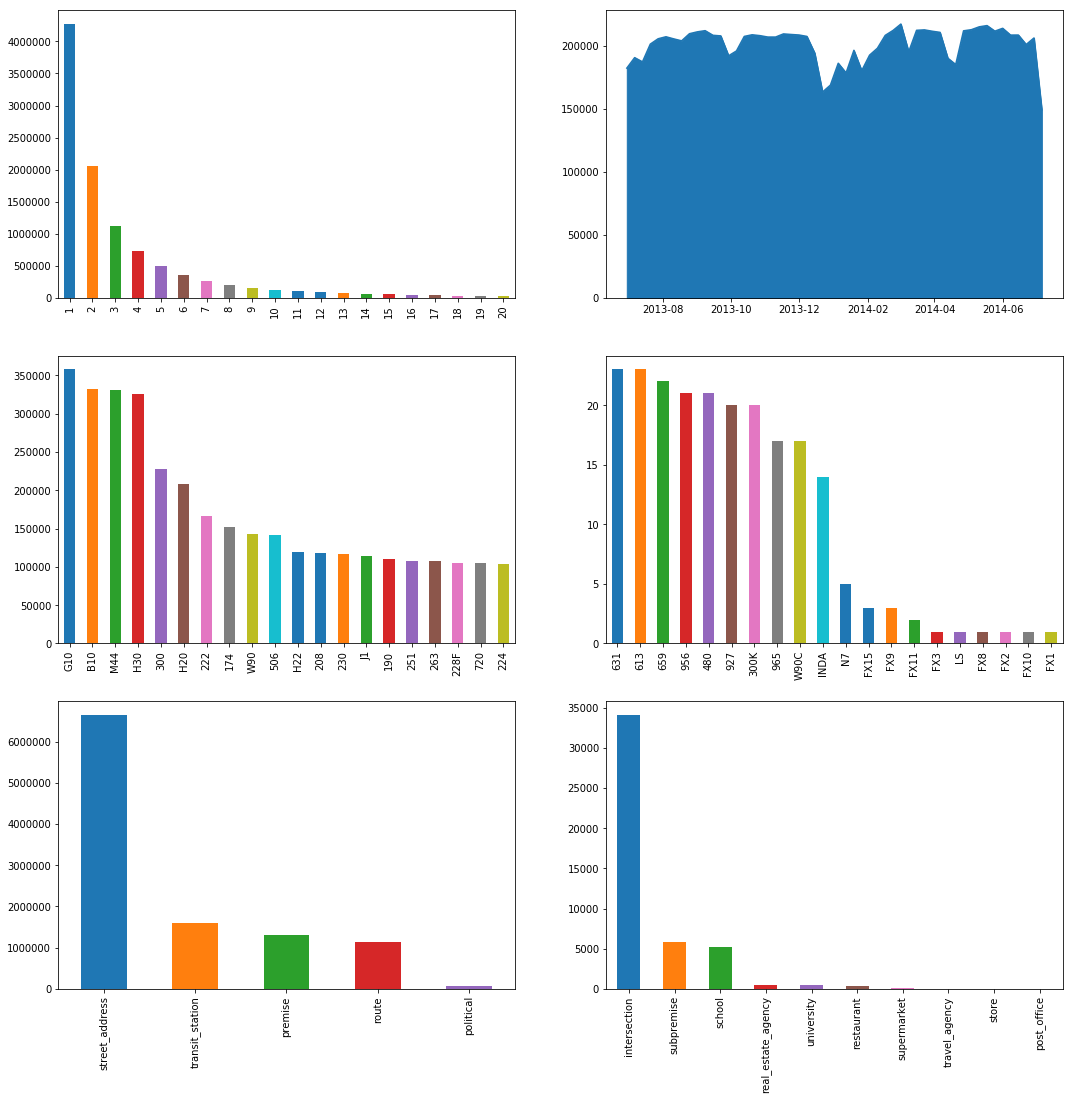

In [32]:
##can assign the each chart to one axes at a time
fig,axrr=plt.subplots(3,2,figsize=(18,18))

data['NumberOfBoardings'].value_counts().sort_index().head(20).plot.bar(ax=axrr[0][0])
data['WeekBeginning'].value_counts().plot.area(ax=axrr[0][1])
data['RouteID'].value_counts().head(20).plot.bar(ax=axrr[1][0])
data['RouteID'].value_counts().tail(20).plot.bar(ax=axrr[1][1])
data['type'].value_counts().head(5).plot.bar(ax=axrr[2][0])
data['type'].value_counts().tail(10).plot.bar(ax=axrr[2][1])

**Inferences**:

* More than 40 lakhs times only single person board from the bus stop.
* There are average of 1.8 lakhs people travel every week by bus in adelaide metropolitan area.
* G10,B10,M44,H30 are the most busiest routes in the city while FX8,FX3,FX10,FX1,FX2 are the least.
* Most of the Bus stops are Street_Address Type while there are very few which are store or post office.

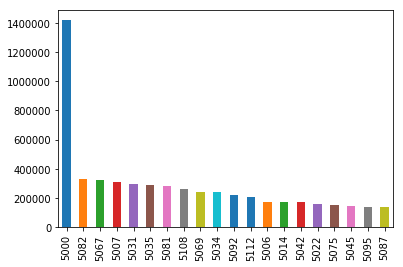

In [33]:
data['postcode'].value_counts().head(20).plot.bar()

In [34]:
# data['dist_from_centre'].nunique()
bb_grp = data.groupby(['dist_from_centre']).agg({'NumberOfBoardings': ['sum']}).reset_index()
bb_grp.columns = bb_grp.columns.get_level_values(0)
bb_grp.head()
bb_grp.columns

,dist_from_centre,NumberOfBoardings
0,0.000018,1892443
1,0.131368,167535
2,0.309089,356518
3,0.314937,1484824
4,0.326005,120061


Index(['dist_from_centre', 'NumberOfBoardings'], dtype='object')

In [35]:
trace0 = go.Scatter(
    x = bb_grp['dist_from_centre'],
    y = bb_grp['NumberOfBoardings'],mode = 'lines+markers',name = 'X2 King William St')

data1 = [trace0]
layout = dict(title = 'Distance Vs Number of boarding',
              xaxis = dict(title = 'Distance from centre'),
              yaxis = dict(title = 'Number of Boardings'))
fig = dict(data=data1, layout=layout)
iplot(fig)

**Inferences**:

* As we move away from centre the number of Boarding decreases
* There are cluster of bus stops near to the main Adelaide city as oppose to outside.so that's why most of boardings are near to center

### Using Bokeh <a id="8"></a>
Plot the Bus stop on the Google Map using the latitude and longitude of the bus stop address

In [36]:
lat = out_geo['latitude'].tolist()
long = out_geo['longitude'].tolist()
nam = out_geo['input_string'].tolist()

In [37]:
map_options = GMapOptions(lat=-34.96, lng=138.592, map_type="roadmap", zoom=9)
key = open('../input/geolockey/api_key.txt').read()
p = gmap(key, map_options, title="Adelaide South Australia")
source = ColumnDataSource(data=dict(lat=lat,lon=long,nam=nam))

p.circle(x="lon", y="lat", size=5, fill_color="blue", fill_alpha=0.8, source=source)
TOOLTIPS = [("Place", "@nam")]
p.add_tools( HoverTool(tooltips=TOOLTIPS))
output_notebook()
show(p)

bokeh.models.renderers.GlyphRenderer(
    id='82ea2a87-3f0b-4302-ad59-eec7cd69bf3f',
    data_source=bokeh.models.sources.ColumnDataSource(
        id='812d2ad7-20b8-46a1-b434-a81ad0c97ee5',
        callback=None,
        data={'lon': [138.5921483,
          138.5923007,
          138.5927151,
          138.551628,
          138.611477,
          138.5523584,
          138.5511989,
          138.5523584,
          138.5484784,
          138.5518486,
          138.5518486,
          138.5312475,
          138.5518486,
          138.63896709999997,
          138.5449643,
          138.6109484,
          138.5518486,
          138.5929147,
          138.55098040000001,
          138.5316035,
          138.552369,
          138.5442499,
          138.5858044,
          138.5518486,
          138.5442499,
          138.59187830000002,
          138.543521,
          138.564249,
          138.5492368,
          138.55170159999997,
          138.55327680000002,
          138.5142021,
          138.5518486,
          138.5504216,
          138.5518486,
          138.5518486,
          138.6104483,
          138.5325959,
          138.5436779,
          138.51414780000002,
          138.5940749,
          138.6111146,
          138.61216140000002,
          138.5523584,
          138.5139968,
          138.6117863,
          138.55170159999997,
          138.5932274,
          138.535,
          138.6133394,
          138.5316774,
          138.5449643,
          138.54915019999999,
          138.6390755,
          138.543521,
          138.543521,
          138.5937564,
          138.6140106,
          138.5518486,
          138.6123834,
          138.5523584,
          138.5518486,
          138.5942116,
          138.6137585,
          138.5940749,
          138.6142686,
          138.59352859999998,
          138.639604,
          138.63940669999997,
          138.63924219999998,
          138.6438231,
          138.639223,
          138.63966399999998,
          138.63961980000002,
          138.64001869999998,
          138.6392906,
          138.5492296,
          138.552369,
          138.5449643,
          138.5442499,
          138.55282549999998,
          138.6395994,
          138.6395791,
          138.6390719,
          138.551277,
          138.6396746,
          138.6252763,
          138.5806534,
          138.6218408,
          138.5812831,
          138.621602,
          138.5813898,
          138.63966399999998,
          138.63924219999998,
          138.6400161,
          138.6396301,
          138.52689840000002,
          138.55245390000002,
          138.5270429,
          138.5517864,
          138.57243689999999,
          138.5515583,
          138.5523757,
          138.55169130000002,
          138.5516915,
          138.568018,
          138.5517697,
          138.5523901,
          138.5271049,
          138.5517241,
          138.5524125,
          138.552278,
          138.5519695,
          138.5523799,
          138.55239519999998,
          138.5271237,
          138.568005,
          138.5693,
          138.55246830000002,
          138.55179909999998,
          138.3240501,
          138.491605,
          138.5644927,
          138.51182580000003,
          138.5123521,
          138.56447769999997,
          138.5125302,
          138.529636,
          138.52455080000001,
          138.5294435,
          138.5641449,
          138.5932529,
          138.5782234,
          138.5932529,
          138.491318,
          138.5872271,
          138.52698759999998,
          138.57176769999998,
          138.5643408,
          138.5932529,
          138.5244981,
          138.5784945,
          138.52455080000001,
          138.5267532,
          138.6052346,
          138.5932529,
          138.60564730000002,
          138.60399130000002,
          138.5676258,
          138.58796909999998,
          138.5784998,
          138.52455080000001,
          138.5118159,
          138.6063451,
          13

Loading BokehJS ...

**Inferences**:

* It has Geospatial coverage Area from Lat: 34.3862 to -35.3655 and Lon: 138.4126 to 139.1089. Which is Total 152 KM long Area from Daniel Road to Mosquito Creek Road on one side and Total 162 KM Stretch from Truro to Myponga Beach on the other side.
* There are cluster of bus stops near to the main Adelaide city as oppose to outside.

### Plot using Plotly <a id="9"></a>

In [38]:
## for finding highest number of Boarding Bus stops
bb_grp = bb.groupby(['StopName']).agg({'NumberOfBoardings_sum': ['sum']}).reset_index()['NumberOfBoardings_sum'].sort_values('sum')
bb_grp[1000:1005]
bb.groupby(['StopName']).agg({'NumberOfBoardings_sum': ['sum']}).reset_index().iloc[[2325,1528,546,1043,1905]]
# bb_grp.iloc[[3054]]

,sum
2325,2644
1528,2652
546,2653
1043,2654
1905,2654


,StopName,NumberOfBoardings_sum
,,sum
2325,57A Hancock Rd,2644
1528,37 Muriel Dr,2652
546,18B Springbank Rd,2653
1043,27E Sir Ross Smith Av,2654
1905,46A Baldock Rd,2654


In [39]:
source_1 = bb[bb['StopName'] == 'X2 King William St'].reset_index(drop = True)
source_2 = bb[bb['StopName'] == 'E1 Currie St'].reset_index(drop = True)
source_3 = bb[bb['StopName'] == 'I2 North Tce'].reset_index(drop = True)
source_4 = bb[bb['StopName'] == 'F2 Grenfell St'].reset_index(drop = True)
source_5 = bb[bb['StopName'] == 'D1 King William St'].reset_index(drop = True)

In [40]:
trace0 = go.Scatter(
    x = source_1['WeekBeginning'],
    y = source_1['NumberOfBoardings_sum'],mode = 'lines+markers',name = 'X2 King William St')
trace1 = go.Scatter(
    x = source_2['WeekBeginning'],
    y = source_2['NumberOfBoardings_sum'],mode = 'lines+markers',name = 'E1 Currie St')
trace2 = go.Scatter(
    x = source_3['WeekBeginning'],
    y = source_3['NumberOfBoardings_sum'],mode = 'lines+markers',name = 'I2 North Tce')
trace3 = go.Scatter(
    x = source_4['WeekBeginning'],
    y = source_4['NumberOfBoardings_sum'],mode = 'lines+markers',name = 'F2 Grenfell St')
trace4 = go.Scatter(
    x = source_5['WeekBeginning'],
    y = source_5['NumberOfBoardings_sum'],mode = 'lines+markers',name = 'D1 King William St')

data = [trace0,trace1,trace2,trace3,trace4]
layout = dict(title = 'Weekly Boarding Total',
              xaxis = dict(title = 'Week Number'),
              yaxis = dict(title = 'Number of Boardings'),
              shapes = [{# Holidays Record: 2013-09-01
'type': 'line','x0': '2013-09-01','y0': 0,'x1': '2013-09-02','y1': 18000,'line': {
        'color': 'rgb(55, 128, 191)','width': 1,'dash': 'dashdot'},},
              {# 2013-10-07
'type': 'line','x0': '2013-10-07','y0': 0,'x1': '2013-10-07','y1': 18000,'line': {
        'color': 'rgb(55, 128, 191)','width': 1,'dash': 'dashdot'},},
              {# 2013-12-25
'type': 'line','x0': '2013-12-25','y0': 0,'x1': '2013-12-26','y1': 18000,'line': {
        'color': 'rgb(55, 128, 191)','width': 3,'dash': 'dashdot'},},
              {# 2014-01-27
'type': 'line','x0': '2014-01-27','y0': 0,'x1': '2014-01-28','y1': 18000,'line': {
        'color': 'rgb(55, 128, 191)','width': 1,'dash': 'dashdot'},},
              {# 2014-03-10
'type': 'line','x0': '2014-03-10','y0': 0,'x1': '2014-03-11','y1': 18000,'line': {
        'color': 'rgb(55, 128, 191)','width': 1,'dash': 'dashdot'},},
              {# 2014-04-18
'type': 'line','x0': '2014-04-18','y0': 0,'x1': '2014-04-19','y1': 18000,'line': {
        'color': 'rgb(55, 128, 191)','width': 3,'dash': 'dashdot'},},
              {# 2014-06-09
'type': 'line','x0': '2014-06-09','y0': 0,'x1': '2014-06-10','y1': 18000,'line': {
        'color': 'rgb(55, 128, 191)','width': 1,'dash': 'dashdot'},},])
fig = dict(data=data, layout=layout)
iplot(fig)

**Inferences**:

* X2 King William St and stop near to that are the most busiest stops in the city. which having number of boardings per week more than 10k.
* Vertical lines are the indicator of holidays which came within that week.
* Whenever there is any Public holiday that week period have less than average number of people travelled from bus.

In [41]:
source_6 = bb[bb['StopName'] == '57A Hancock Rd'].reset_index(drop = True)
source_7 = bb[bb['StopName'] == '37 Muriel Dr'].reset_index(drop = True)
source_8 = bb[bb['StopName'] == '18B Springbank Rd'].reset_index(drop = True)
source_9 = bb[bb['StopName'] == '27E Sir Ross Smith Av'].reset_index(drop = True)
source_10 = bb[bb['StopName'] == '46A Baldock Rd'].reset_index(drop = True)

In [42]:
trace0 = go.Scatter(
    x = source_6['WeekBeginning'],
    y = source_6['NumberOfBoardings_sum'],mode = 'lines+markers',name = '57A Hancock Rd')
trace1 = go.Scatter(
    x = source_7['WeekBeginning'],
    y = source_7['NumberOfBoardings_sum'],mode = 'lines+markers',name = '37 Muriel Dr')
trace2 = go.Scatter(
    x = source_8['WeekBeginning'],
    y = source_8['NumberOfBoardings_sum'],mode = 'lines+markers',name = '18B Springbank Rd')
trace3 = go.Scatter(
    x = source_9['WeekBeginning'],
    y = source_9['NumberOfBoardings_sum'],mode = 'lines+markers',name = '27E Sir Ross Smith Av')
trace4 = go.Scatter(
    x = source_10['WeekBeginning'],
    y = source_10['NumberOfBoardings_sum'],mode = 'lines+markers',name = '46A Baldock Rd')

data = [trace0,trace1,trace2,trace3,trace4]
layout = dict(title = 'Weekly Boarding Total',
              xaxis = dict(title = 'Week Number'),
              yaxis = dict(title = 'Number of Boardings'),
              shapes = [{# Holidays Record: 2013-09-01
'type': 'line','x0': '2013-09-01','y0': 0,'x1': '2013-09-02','y1': 80,'line': {
        'color': 'rgb(55, 128, 191)','width': 1,'dash': 'dashdot'},},
              {# 2013-10-07
'type': 'line','x0': '2013-10-07','y0': 0,'x1': '2013-10-07','y1': 80,'line': {
        'color': 'rgb(55, 128, 191)','width': 1,'dash': 'dashdot'},},
              {# 2013-12-25
'type': 'line','x0': '2013-12-25','y0': 0,'x1': '2013-12-26','y1': 80,'line': {
        'color': 'rgb(55, 128, 191)','width': 3,'dash': 'dashdot'},},
              {# 2014-01-27
'type': 'line','x0': '2014-01-27','y0': 0,'x1': '2014-01-28','y1': 80,'line': {
        'color': 'rgb(55, 128, 191)','width': 1,'dash': 'dashdot'},},
              {# 2014-03-10
'type': 'line','x0': '2014-03-10','y0': 0,'x1': '2014-03-11','y1': 80,'line': {
        'color': 'rgb(55, 128, 191)','width': 1,'dash': 'dashdot'},},
              {# 2014-04-18
'type': 'line','x0': '2014-04-18','y0': 0,'x1': '2014-04-19','y1': 80,'line': {
        'color': 'rgb(55, 128, 191)','width': 3,'dash': 'dashdot'},},
              {# 2014-06-09
'type': 'line','x0': '2014-06-09','y0': 0,'x1': '2014-06-10','y1': 80,'line': {
        'color': 'rgb(55, 128, 191)','width': 1,'dash': 'dashdot'},},])
fig = dict(data=data, layout=layout)
iplot(fig)

**Inferences**:

* Same decreasing affect of Holidays on number of people travelling through bus can be seen in other city bus stops also.
* The width of vertical blue line shows the number of holidays come within that week period.
* Two thickest blue lines shows Christmas and New year period while other one was easter & Good friday period.on both the occassion number of public holidays within week period was 3.

## Propositions <a id="11"></a>

Rate of change in the traffic pattern in all different bus stops.

In [48]:
d=[]
for i in bb['StopName'].unique():
    d.append({'StopName': i,'Boarding_sum':np.sum(bb[bb['StopName'] == i]['NumberOfBoardings_sum'].pct_change())/54,
             'Boarding_count':np.sum(bb[bb['StopName'] == i]['NumberOfBoardings_count'].pct_change())/54,
             'Boarding_max':np.sum(bb[bb['StopName'] == i]['NumberOfBoardings_max'].pct_change())/54})
pct_chng = pd.DataFrame(d)

In [49]:
#pct_chng.head()
pct_chng['Boarding_sum'].nlargest(5)
pct_chng['Boarding_sum'].nsmallest(5)
pct_chng[pct_chng['Boarding_sum']<0].shape
pct_chng.iloc[[3110,2134,214,1538,1290]]

3110    9.610182
2134    4.454329
214     2.678186
1538    2.153380
1290    1.913630
Name: Boarding_sum, dtype: float64

1672   -0.011979
250    -0.011317
3115   -0.010744
1840   -0.009904
1113   -0.008562
Name: Boarding_sum, dtype: float64

(27, 4)

,Boarding_count,Boarding_max,Boarding_sum,StopName
3110,2.183068,0.301880,9.610182,W Grote St
2134,0.250926,5.611376,4.454329,52 Taylors Rd
214,0.153529,2.273410,2.678186,13 Tutt Av
1538,0.115724,4.608867,2.153380,37A Longwood Rd
1290,0.148205,2.500424,1.913630,32A Frederick Rd


**Inferences**:

* These 5 stops W Grote St,52 Taylors Rd,13 Tutt Av,37A Longwood Rd,32A Frederick Rd having the largest percent increase.
* There are 27 Bus stops where number of boardings have decreased.
* The number of busses can be found by taking the number of boarding divided by bus capacity which can take as 50.

## Predictive Modelling <a id="12"></a>

Get info like RouteID,latitude,longitude,postcode,dist_from_centre & holiday_label 6 features from the main dataset

In [50]:
bb1 = pd.merge(bb, out_geo, how='left', left_on = 'StopName', right_on = 'input_string')

In [51]:
bb1['holiday_label'] = bb1['WeekBeginning'].apply (lambda row: holiday_label(row))

In [52]:
##Final 11 features have been used for the forecastng.
cols = ['StopName','WeekBeginning','type_x','NumberOfBoardings_sum','NumberOfBoardings_count','NumberOfBoardings_max','latitude','longitude','postcode','dist_from_centre','holiday_label']
bb1=bb1[cols]
bb1.shape
bb1.head()

(175446, 11)

,StopName,WeekBeginning,type_x,NumberOfBoardings_sum,NumberOfBoardings_count,NumberOfBoardings_max,latitude,longitude,postcode,dist_from_centre,holiday_label
0,1 Anzac Hwy,2013-06-30,street_address,1003,378,51,-34.942418,138.58183,5035,3.151684,0
1,1 Anzac Hwy,2013-07-07,street_address,783,360,28,-34.942418,138.58183,5035,3.151684,0
2,1 Anzac Hwy,2013-07-14,street_address,843,343,45,-34.942418,138.58183,5035,3.151684,0
3,1 Anzac Hwy,2013-07-21,street_address,710,356,28,-34.942418,138.58183,5035,3.151684,0
4,1 Anzac Hwy,2013-07-28,street_address,898,379,41,-34.942418,138.58183,5035,3.151684,0


In [53]:
##Replace all Nan by Mode
for i in bb1.columns:
    bb1[i].fillna(bb1[i].mode()[0], inplace=True)
bb1[["postcode", "holiday_label"]] = bb1[["postcode", "holiday_label"]].apply(pd.to_numeric)

Label Encode the Categorical data

In [54]:
le = LabelEncoder()
bb1['StopName'] = le.fit_transform(bb1['StopName'])
bb1['type_x'] = le.fit_transform(bb1['type_x'])

Split into Train Test for Modelling further

In [55]:
train = bb1[bb1['WeekBeginning'] < datetime.date(2014, 6, 1)]
test = bb1[bb1['WeekBeginning'] >= datetime.date(2014, 6, 1)]
train.shape
test.shape

(155952, 11)

(19494, 11)

In [56]:
le = LabelEncoder()
train['WeekBeginning'] = le.fit_transform(train['WeekBeginning'])
test['WeekBeginning'] = le.fit_transform(test['WeekBeginning'])

In [57]:
# tr_col = ['StopName', 'WeekBeginning', 'type_x', 'latitude',
#        'longitude', 'postcode', 'dist_from_centre', 'holiday_label']
# tr_target = ['StopName','NumberOfBoardings_sum','NumberOfBoardings_count','NumberOfBoardings_max']
# train1 = train[tr_col]
# test1 = test[tr_col]
# train_tg = train[tr_target]
# test_tg = test[tr_target]

In [58]:
# ## model each StopName Separately
# train.StopName.nunique()
# for i in train['StopName']:
#     col = 'NumberOfBoardings_sum'
#     train_x = train1[train1['StopName']==i]
#     test_x = test1[test1['StopName']==i]
#     tr_target = train_tg[train_tg['StopName'] ==i][col]
#     ts_target = test_tg[test_tg['StopName'] == i][col]
#     print(i,train_x.shape,test_x.shape,tr_target.shape,ts_target.shape)
#     xgb_model = xg.XGBRegressor()
#     xgb_model.fit(train_x.values,tr_target.values)
#     preds = xgb_model.predict(test_x.values)
#     print('original ',ts_target)
#     print('prediction: ',preds)
#     break

In [59]:
tr_col = ['StopName', 'WeekBeginning', 'type_x', 'latitude',
       'longitude', 'postcode', 'dist_from_centre', 'holiday_label']
train_sum_y = train[['StopName','NumberOfBoardings_sum']]
train_count_y = train[['StopName','NumberOfBoardings_count']]
train_max_y = train[['StopName','NumberOfBoardings_max']]
train_x = train[tr_col]
test_x = test[tr_col]

test_sum_y = test[['StopName','NumberOfBoardings_sum']]
test_count_y = test[['StopName','NumberOfBoardings_count']]
test_max_y = test[['StopName','NumberOfBoardings_max']]

Modelling using regression models.
1. lightGbm Regressor
2. Gru

### Using LightGbm <a id="13"></a>

In [60]:
from sklearn.ensemble import RandomForestRegressor
# model = lgb.LGBMRegressor()
model = RandomForestRegressor(n_estimators=700, min_samples_leaf=3, max_features=0.5,n_jobs=-1)
# model = lgb.LGBMRegressor(max_depth=10,learning_rate=0.0227,n_estimators=195,num_leaves=11,reg_alpha=1.5764,reg_lambda=0.0478,subsample=0.7776,colsample_bytree=0.7761)
model.fit(train_x.values,train_sum_y['NumberOfBoardings_sum'].values)
preds = model.predict(test_x.values)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [61]:
rms = sqrt(mean_squared_error(test_sum_y['NumberOfBoardings_sum'].values, preds))
rms

320.9639554159831

Let's see how actual and predicted values compared with each other from first 15 index

In [62]:
test_sum_y.values[:15]
preds[:15]

array([[  0, 613],
       [  0, 590],
       [  0, 700],
       [  0, 632],
       [  0, 876],
       [  0, 465],
       [  1, 205],
       [  1, 152],
       [  1, 173],
       [  1, 163],
       [  1, 157],
       [  1,  98],
       [  2, 270],
       [  2, 247],
       [  2, 251]])

array([896.66778248, 812.40157774, 896.40390946, 895.90332613,
       911.66243662, 923.4092817 , 147.2846439 , 129.02719201,
       147.63253165, 151.98204174, 155.59990756, 163.86998949,
       272.23269974, 243.94921812, 272.23269974])

TypeError: booster must be Booster or LGBMModel.

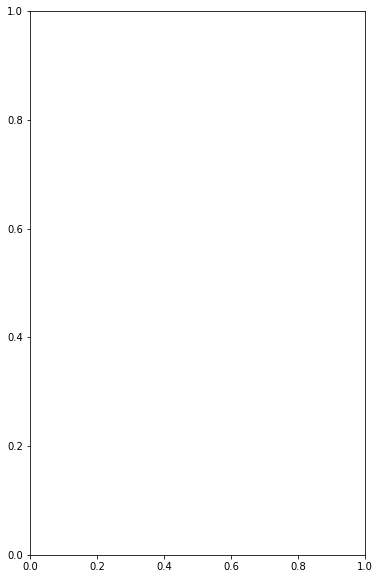

In [63]:
fig, ax = plt.subplots(figsize=(6,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

<Figure size 1080x360 with 0 Axes>

Text(0,0.5,'Total Number of Boarding')

Text(0.5,0,'Index')

Text(0.5,1,'Comparison Between Prediction & True Values')

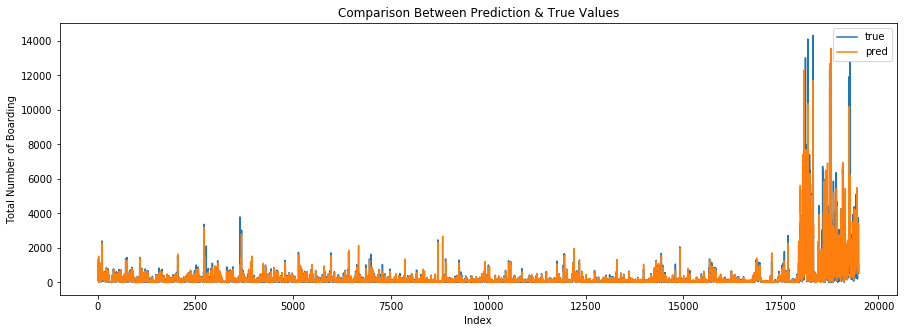

In [64]:
plt.figure(figsize=(15,5))
plt.plot(test_sum_y['NumberOfBoardings_sum'].values, label='true')
plt.plot(preds, label='pred')
plt.ylabel("Total Number of Boarding")
plt.xlabel("Index")
plt.title("Comparison Between Prediction & True Values")
plt.legend()
plt.show()

### Results
* we have trained the model for 48 weeks and test on last 6 weeks for all stopping points.
* High Rmse value came because we didn't scale the values.so we got the actual prediction instead of scaled prediction

### Using Gru <a id="14"></a>

In [65]:
bb1['WeekBeginning'] = le.fit_transform(bb1['WeekBeginning'])

In [66]:
df = bb1.sort_values(['WeekBeginning','StopName'])

In [67]:
##Replace all Nan by Mode
for i in df.columns:
    df[i].fillna(df[i].mode()[0], inplace=True)
df[["postcode", "holiday_label"]] = df[["postcode", "holiday_label"]].apply(pd.to_numeric)

In [68]:
target_names = ['NumberOfBoardings_sum', 'NumberOfBoardings_count', 'NumberOfBoardings_max']
train_col = ['StopName','WeekBeginning','type_x','latitude','longitude','postcode','dist_from_centre','holiday_label']
##want to predict 1 day in future.
shift_days = 6
shift_steps = shift_days * 3249

In [69]:
df_targets = df[target_names].shift(-shift_steps)
x_data = df.iloc[:,1:].values[0:-shift_steps]
y_data = df_targets.values[:-shift_steps]
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (155952, 3)


In [70]:
##data split into 90% training and 10% testing
num_data = len(x_data)
train_split = 0.9
num_train = int(train_split * num_data)
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
print(len(x_train) + len(x_test))

155952


In [71]:
##target values for test and train
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
print(len(y_train) + len(y_test))
##input dimension and output dimension
num_x_signals = x_data.shape[1]
print(num_x_signals)
num_y_signals = y_data.shape[1]
print(num_y_signals)

155952
10
3


In [72]:
##scale data to get values between 0 to 1.
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))
x_test_scaled = x_scaler.transform(x_test)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
print(x_train_scaled.shape)
print(y_train_scaled.shape)

Min: -119.4179324
Max: 31791.0
Min: 0.0
Max: 1.0000000000000002
(140356, 10)
(140356, 3)


In [73]:
def batch_generator(batch_size, sequence_length):
    while True:
        # Allocate a new array for the batch of input,output signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        for i in range(batch_size):
            idx = np.random.randint(num_train - sequence_length)
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        yield (x_batch, y_batch)

In [74]:
batch_size = 256
sequence_length = 1344
print(sequence_length)
generator = batch_generator(batch_size=batch_size,sequence_length=sequence_length)
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

1344
(256, 1344, 10)
(256, 1344, 3)


In [75]:
##model
model = Sequential()
model.add(LSTM(units=512,return_sequences=True,input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid'))

In [76]:
#loss function define.
warmup_steps = 0
def loss_mse_warmup(y_true, y_pred):
    # [batch_size, sequence_length, num_y_signals].
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]
    # Calculate the MSE loss for each value in these tensors.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,predictions=y_pred_slice)
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

In [77]:
##optimizer and model summary
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 512)         1071104   
_________________________________________________________________
dense (Dense)                (None, None, 3)           1539      
Total params: 1,072,643
Trainable params: 1,072,643
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
##early stopping and learning rate decrease callbacks
callback_early_stopping = EarlyStopping(monitor='val_loss',patience=5, verbose=1)
callbacks = [callback_early_stopping]

In [79]:
%%time
#model.fit(generator=generator,epochs=2,steps_per_epoch=5,validation_data=validation_data,callbacks=callbacks)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10 µs


In [80]:
# model.load_weights(path_checkpoint)
# result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
#                         y=np.expand_dims(y_test_scaled, axis=0))
# print("loss (test-set):", result)

## Future Work <a id="15"></a>

* Calculates the number of people commuting within a specific route.
* Propose the means of commute based upon market information.

....